### Data Understanding, Analysis, Visualization and Cleaning

In [ ]:
# /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Copy of Copy of Brain Tumor Classifcation-20250508T163722Z-1-001.zip

In [ ]:
# base_dir = "/content/drive/MyDrive/Level 6/AI & ML/Portfolio/"
# zip_path = base_dir + "Copy of Copy of Brain Tumor Classifcation-20250508T163722Z-1-001.zip"

# !unzip -q "$zip_path" -d "$base_dir"


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:

# Define dataset path
train_path = "/content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train"
test_path = "/content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/test"


### Verify Dataset

In [ ]:
import os

# Define dataset path
train_dir = train_path

# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))

if not class_names:
    print("No class directories found in the train folder!")
else:
    print(f"Found {len(class_names)} classes: {class_names}")


Found 4 classes: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [ ]:
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

In [ ]:
import os
from collections import Counter

classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'normal']

def get_unique_extensions(directory, classes):
    extensions = []
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        for file in os.listdir(class_dir):
            ext = os.path.splitext(file)[1].lower()
            if ext:
                extensions.append(ext)
    return Counter(extensions)

train_extensions = get_unique_extensions(train_path, classes)
test_extensions = get_unique_extensions(test_path, classes)

print("Train image extensions:", train_extensions)
print("Test image extensions:", test_extensions)


Train image extensions: Counter({'.jpg': 2447})
Test image extensions: Counter({'.jpg': 621})


### Check for Corrupted Images:

In [ ]:
def find_corrupt_images(directory, classes):
    corrupt_files = []
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # This will raise an exception if the file is not a valid image
            except Exception as e:
                corrupt_files.append(file_path)
                print(f"Corrupt image: {file_path} ({e})")
    return corrupt_files

corrupt_train = find_corrupt_images(train_path, classes)
corrupt_test = find_corrupt_images(test_path, classes)

print(f"Corrupt train images: {len(corrupt_train)}")
print(f"Corrupt test images: {len(corrupt_test)}")


Corrupt image: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg (cannot identify image file '/content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg')
Corrupt image: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg (cannot identify image file '/content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg')
Corrupt image: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_107.jpg (cannot identify image file '/content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_107.jpg')
Corrupt image: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_839.jpg (cannot identify image file '/content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/

In [ ]:
for file_path in corrupt_train + corrupt_test:
    os.remove(file_path)
    print(f"Removed: {file_path}")


Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_107.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_839.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_744.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_560.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/glioma_tumor/G_737.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/meningioma_tumor/M_154.jpg
Removed: /content/drive/MyDrive/Level 6/AI & ML/Portfolio/Brain Tumor Classifcation/train/meni

In [ ]:
from PIL import Image
import os

def find_corrupt_images(directory, classes):
    corrupt_files = []
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # This will raise an exception if the file is not a valid image
            except Exception as e:
                corrupt_files.append(file_path)
                print(f"Corrupt image: {file_path} ({e})")
    return corrupt_files

corrupt_train = find_corrupt_images(train_path, classes)
corrupt_test = find_corrupt_images(test_path, classes)

print(f"Corrupt train images: {len(corrupt_train)}")
print(f"Corrupt test images: {len(corrupt_test)}")


Corrupt train images: 0
Corrupt test images: 0


### Check class distribution

In [ ]:
# Check class distribution
class_counts = {}
for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path)
                 if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)




Class Distribution:
Class Name               Valid Image Count
glioma_tumor                         713
meningioma_tumor                     723
pituitary_tumor                      668
normal                               343


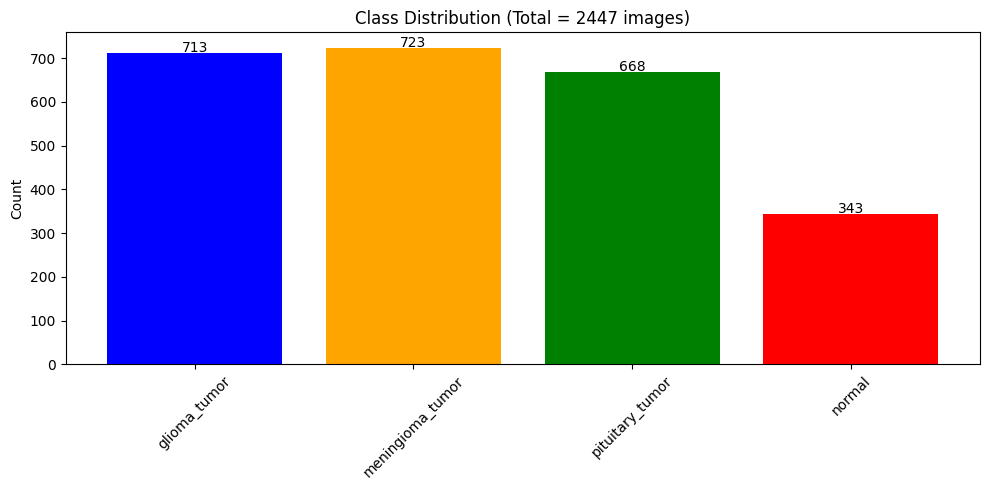

In [ ]:
# Prepare data for plotting
CLASS_NAMES = list(class_counts.keys())
CLASS_COUNTS = list(class_counts.values())
TOTAL_IMAGES = sum(CLASS_COUNTS)

# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.bar(CLASS_NAMES, CLASS_COUNTS, color=['blue', 'orange', 'green', 'red'])
plt.title("Class Distribution (Total = {} images)".format(TOTAL_IMAGES))
plt.ylabel("Count")
plt.xticks(rotation=45)
for i, count in enumerate(CLASS_COUNTS):
    plt.text(i, count + 2, str(count), ha='center')  # Adjust 2 for spacing
plt.tight_layout()
plt.show()

### Select Random Images for Visualization

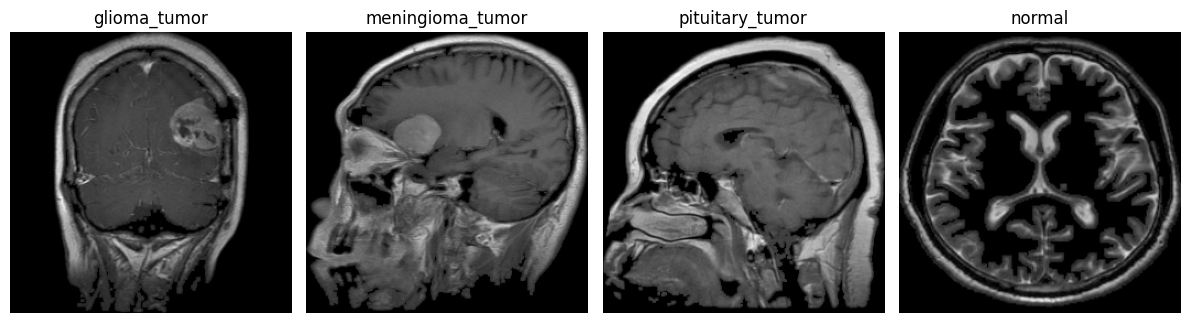

In [ ]:
# Visualize random images from each class
selected_images = []
selected_labels = []
for class_name in classes:
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path)
                 if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

# Plot the selected images
plt.figure(figsize=(12, 6))
for i in range(len(selected_images)):
    img = plt.imread(selected_images[i])
    plt.subplot(1, len(selected_images), i+1)
    plt.imshow(img)
    plt.title(selected_labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


## Data Generation and Pre - processing:

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 2447 files belonging to 4 classes.
Using 2080 files for training.
Found 2447 files belonging to 4 classes.
Using 367 files for validation.


### Understanding train ds and val ds:

In [ ]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)


Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [ ]:
for images, labels in val_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)


Images shape: (32, 224, 224, 3)
Labels shape: (32,)


### Visualizing training dataset

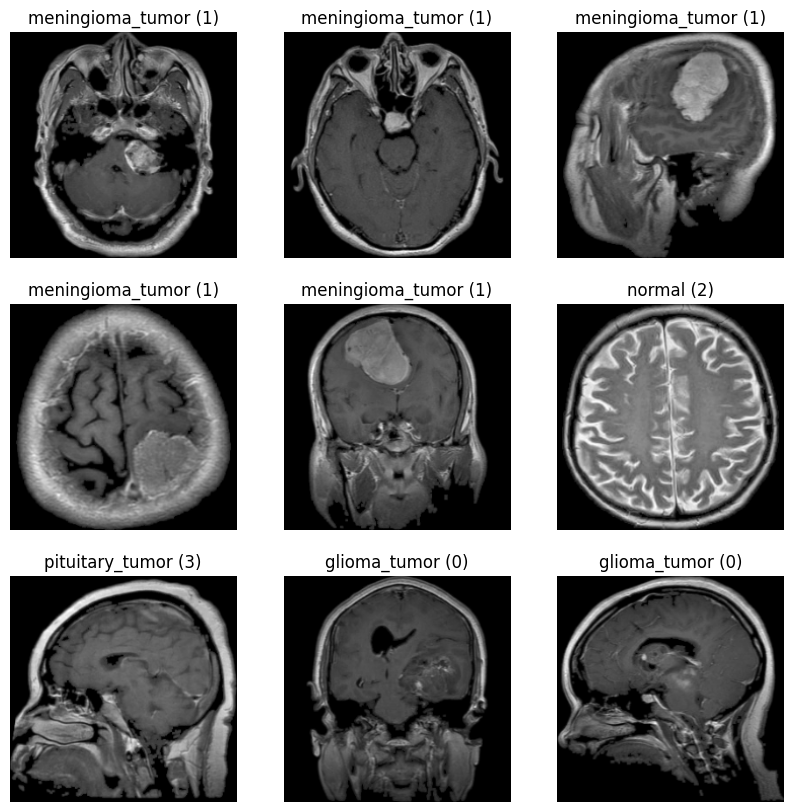

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        class_index = int(labels[i])
        class_label = class_names[class_index]
        plt.title(f"{class_label} ({class_index})")
        plt.axis("off")


### data augmentation

In [ ]:
from tensorflow.keras.models import Sequential

# Data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1, fill_mode="nearest"),
    layers.RandomZoom(0.1, fill_mode="nearest"),
], name="augmentation")



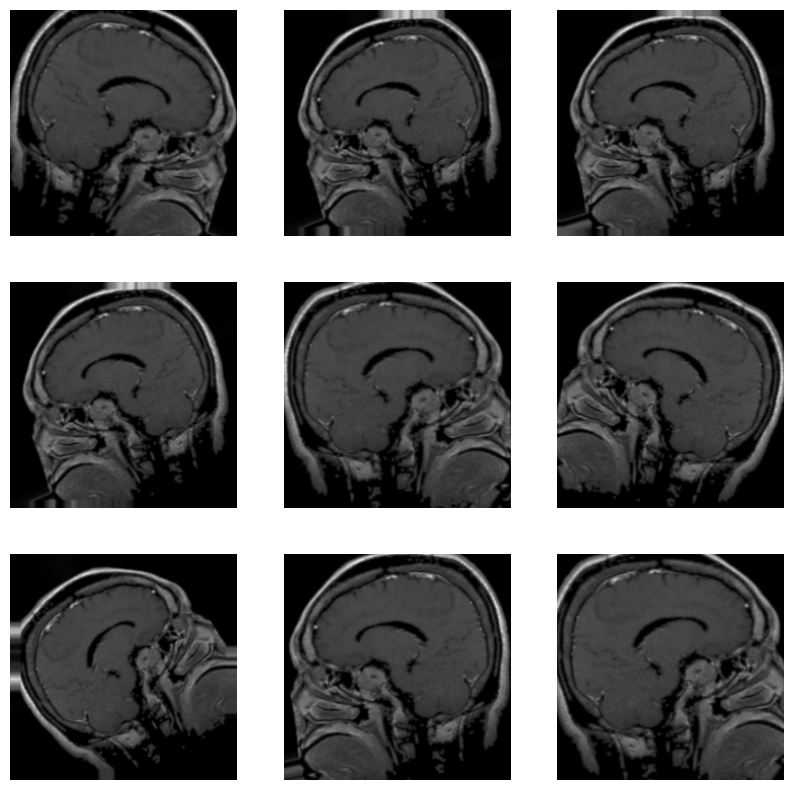

In [ ]:
# Visualize augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

#  Baseline Mode
Design, Train, and Evaluate

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (224, 224, 3)
num_classes = 4

# Define the model
inputs = tf.keras.Input(shape=input_shape)

x = data_augmentation(inputs)  # Augmentation
x = layers.Rescaling(1./255)(x)  # Normalization

# Conv Block 1
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 2
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Conv Block 3
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)


# Flatten the output to connect it to the fully connected layers
x = layers.Flatten()(x)

# Fully Connected Layer 1
x = layers.Dense(128, activation='relu')(x)

# Fully Connected Layer 2
x = layers.Dense(64, activation='relu')(x)

# Fully Connected Layer 3
x = layers.Dense(32, activation='relu')(x)

# Output layer
x = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
base_model = tf.keras.Model(inputs, x)

# Print the model summary to analyze the architecture
base_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,428 (42.65 MB)

 Trainable params: 11,179,428 (42.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
base_model.compile(
   optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001
)



In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

base_history = None

with tf.device('/GPU:0'):
    print("Training on GPU")
    base_history = base_model.fit(
        train_ds,
        epochs=60,
        validation_data=val_ds,
        callbacks=[early_stopping, lr_schedule],
        verbose=1
    )


Training on GPU
Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 387s 6s/step - accuracy: 0.4008 - loss: 8.9007 - val_accuracy: 0.6540 - val_loss: 0.9323 - learning_rate: 0.0010
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 64s 112ms/step - accuracy: 0.7173 - loss: 0.7376 - val_accuracy: 0.6403 - val_loss: 0.9152 - learning_rate: 0.0010
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.8409 - loss: 0.4149 - val_accuracy: 0.7112 - val_loss: 0.9078 - learning_rate: 0.0010
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8883 - loss: 0.3055 - val_accuracy: 0.7738 - val_loss: 0.8043 - learning_rate: 0.0010
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9393 - loss: 0.1524 - val_accuracy: 0.7711 - val_loss: 0.9168 - learning_rate: 0.0010
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9821 - loss: 0.0601 - val_accuracy: 0.7875 - val_loss: 1.0525 - learning_rate: 0.0010
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9718 

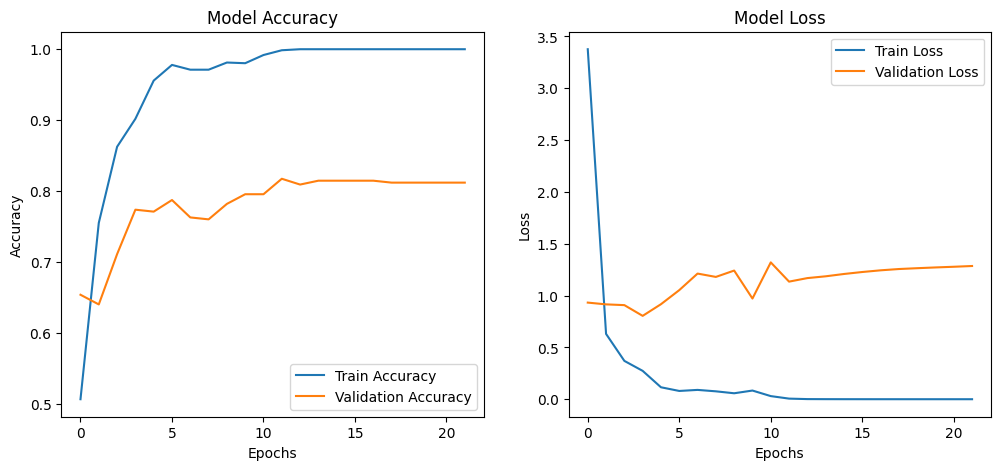

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(base_history.history['accuracy'], label='Train Accuracy')
plt.plot(base_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(base_history.history['loss'], label='Train Loss')
plt.plot(base_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
# Load test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 621 files belonging to 4 classes.


In [ ]:
# Evaluate accuracy and loss
test_loss, test_accuracy = base_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.8101 - loss: 1.3165
Test Accuracy: 0.8293


In [ ]:
# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = base_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Print classification report
from sklearn.metrics import classification_report

print("Classification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=class_names))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.80      0.81       181
meningioma_tumor       0.78      0.79      0.78       183
          normal       0.85 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


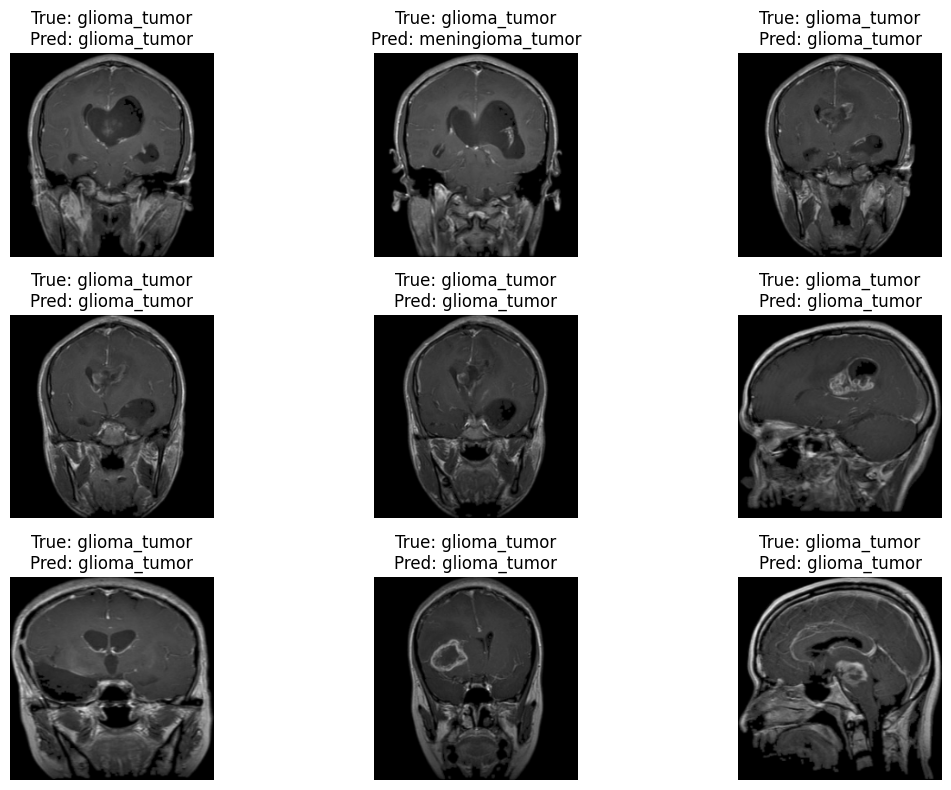

In [ ]:
for images, labels in test_ds.take(1):  # One batch
    predictions = base_model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
test_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 621 files belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


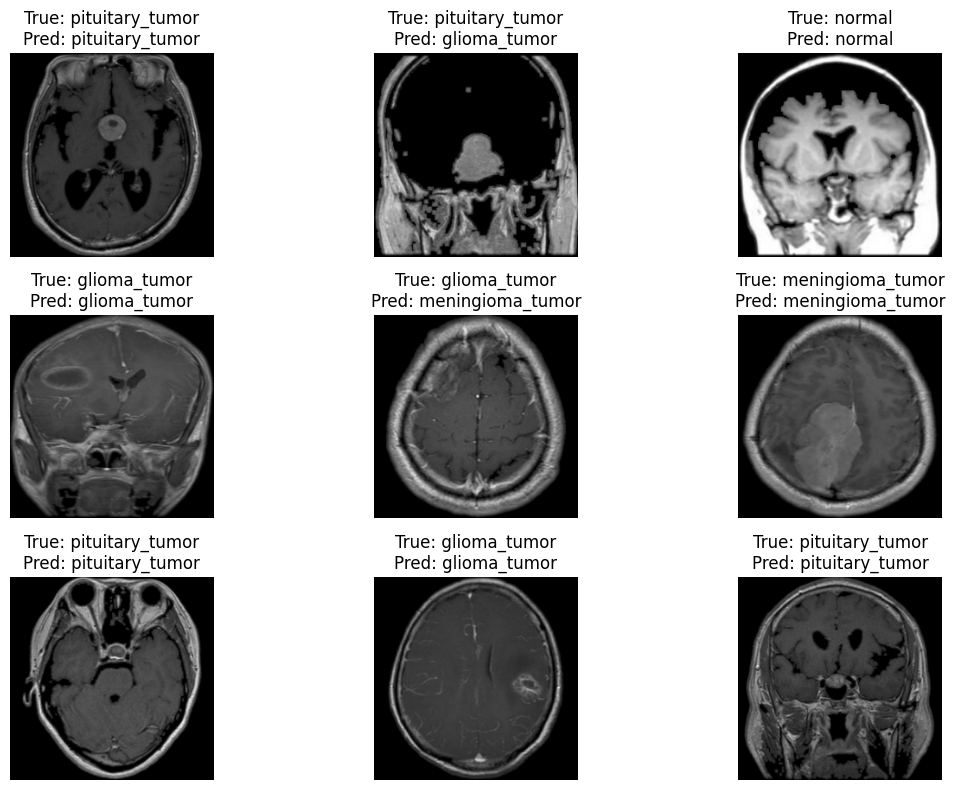

In [ ]:
for images, labels in test_ds2.take(1):  # One batch
    predictions = base_model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


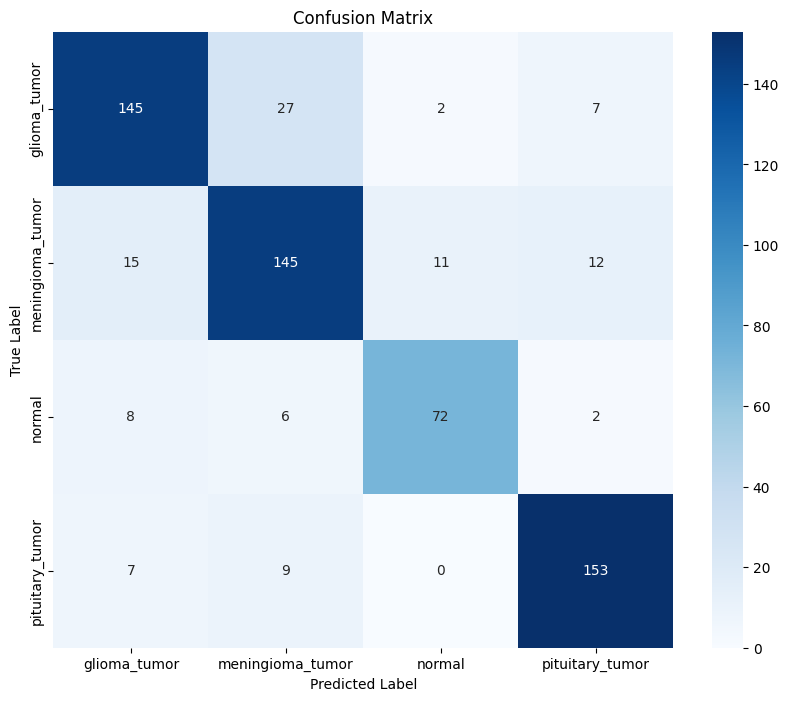

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Discuss key observations about model performance.

# Deeper Model

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 2447 files belonging to 4 classes.
Using 2080 files for training.
Found 2447 files belonging to 4 classes.
Using 367 files for validation.


In [ ]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)


Images shape: (32, 224, 224, 3)
Labels shape: (32,)


In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1, fill_mode="nearest"),
    layers.RandomZoom(0.1, fill_mode="nearest"),
], name="augmentation")



In [ ]:
input_shape = (224, 224, 3)
num_classes = 4


def build_deep_model(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)
    x = data_augmentation(inputs)  # Augmentation
    x = layers.Rescaling(1./255)(x)  # Normalization

    # First conv layer
    x = layers.Conv2D(32, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second conv layer
    x = layers.Conv2D(32, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # 3rd conv layer
    x = layers.Conv2D(64, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 4th conv layer
    x = layers.Conv2D(64, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # 5th conv layer
    x = layers.Conv2D(128, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    #  6th conv layer
    x = layers.Conv2D(128, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Flatten the output of the last Conv2D layer
    x = layers.Flatten()(x)

    # Dense Block 1
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Dense Block 2
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Dense Block 3
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Dense Block 4
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Dense Block 5
    x = layers.Dense(32)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)


    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="DeepCNN_model")
    return model



# Build and summarize model
deep_model = build_deep_model(input_shape, num_classes)
deep_model.summary()


Model: "DeepCNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,848,196 (197.79 MB)

 Trainable params: 51,845,316 (197.77 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
deep_model.compile(
   optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001
)



In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

history = None

with tf.device('/GPU:0'):
    print("Training on GPU")
    history = deep_model.fit(
        train_ds,
        epochs=60,
        validation_data=val_ds,
        callbacks=[early_stopping, lr_schedule],
        verbose=1
    )


Training on GPU
Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 376ms/step - accuracy: 0.3808 - loss: 3.2816 - val_accuracy: 0.2725 - val_loss: 4.8935 - learning_rate: 0.0010
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.6076 - loss: 3.6571 - val_accuracy: 0.2725 - val_loss: 5.0222 - learning_rate: 0.0010
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 346ms/step - accuracy: 0.6394 - loss: 3.3705 - val_accuracy: 0.2752 - val_loss: 4.3960 - learning_rate: 0.0010
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 364ms/step - accuracy: 0.6928 - loss: 2.9729 - val_accuracy: 0.2752 - val_loss: 5.1146 - learning_rate: 0.0010
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - accuracy: 0.7085 - loss: 2.6090 - val_accuracy: 0.3243 - val_loss: 4.7939 - learning_rate: 0.0010
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - accuracy: 0.7092 - loss: 2.4077 - val_accuracy: 0.3597 - val_loss: 4.2088 - learning_rate: 0.0010
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 347ms/step - accuracy: 0

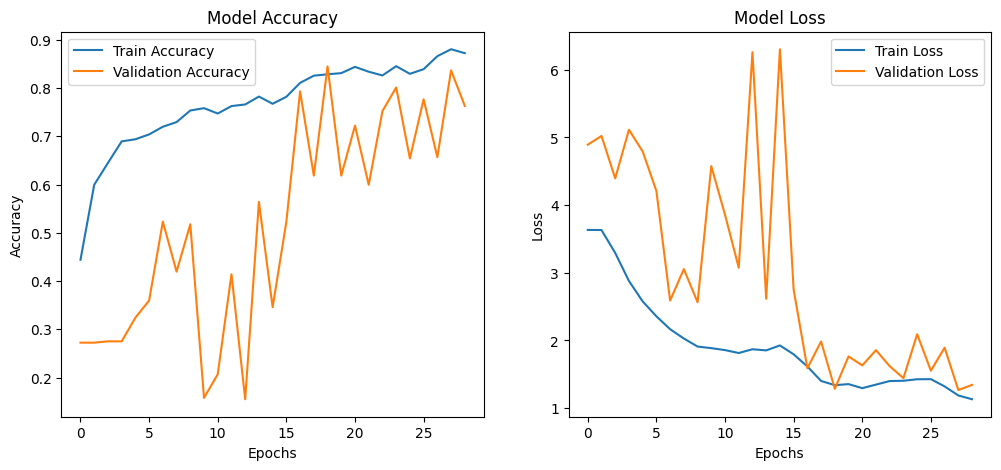

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
# Load test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)



Found 621 files belonging to 4 classes.


In [ ]:
# Evaluate accuracy and loss
test_loss, test_accuracy = deep_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8536 - loss: 1.2873
Test Accuracy: 0.8551


In [ ]:
# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = deep_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Print classification report
from sklearn.metrics import classification_report

print("Classification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=class_names))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    glioma_tumor       0.88      0.80      0.84       181
meningioma_tumor       0.75      0.86      0.80       183
          normal 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


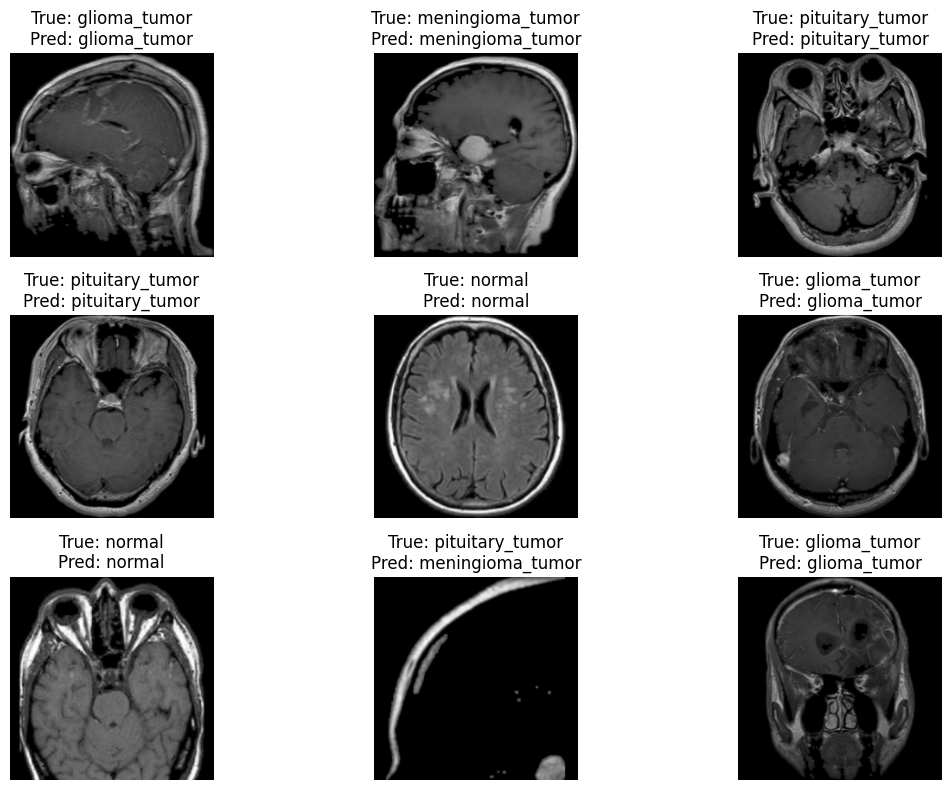

In [ ]:
for images, labels in test_ds.take(1):  # One batch
    predictions = deep_model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


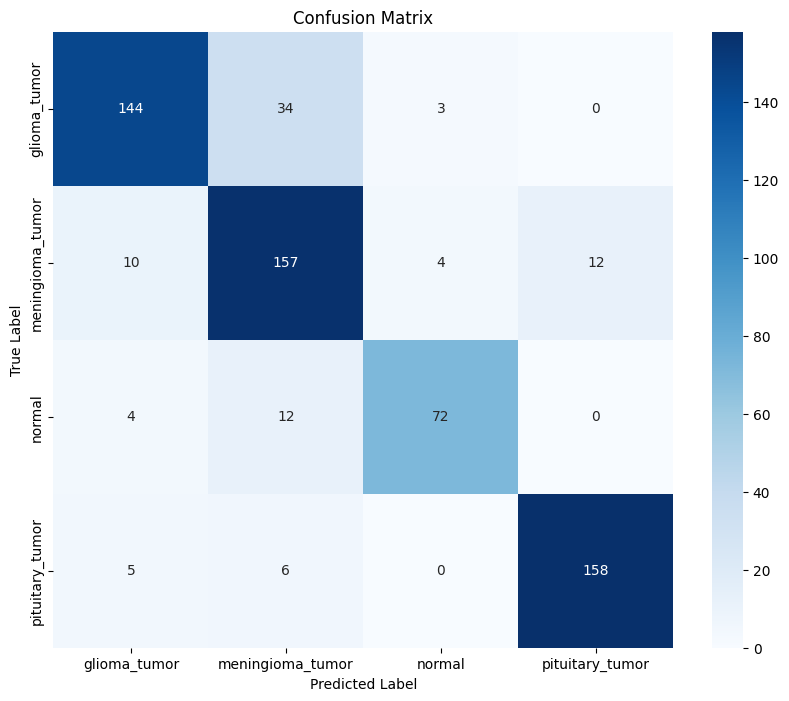

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Optimizer Analysis: SGD vs Adam [5]:
• Train the deeper model with SGD and then Adam.
• Compare the impact of these optimizers on convergence speed and final performance.

In [ ]:
# Build and summarize model
deep_model_sdg = build_deep_model(input_shape, num_classes)
deep_model_sdg.summary()

Model: "DeepCNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,848,196 (197.79 MB)

 Trainable params: 51,845,316 (197.77 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
from tensorflow.keras.optimizers import SGD

# Compile the model with SGD optimizer
sgd_optimizer = SGD()

deep_model_sdg.compile(optimizer=sgd_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001
)




In [ ]:
sgd_history = deep_model_sdg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 343ms/step - accuracy: 0.8393 - loss: 1.3145 - val_accuracy: 0.8665 - val_loss: 1.3135 - learning_rate: 0.0100
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.8537 - loss: 1.2603 - val_accuracy: 0.7112 - val_loss: 1.7087 - learning_rate: 0.0100
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.8437 - loss: 1.2825 - val_accuracy: 0.4060 - val_loss: 2.4112 - learning_rate: 0.0100
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.8587 - loss: 1.2785 - val_accuracy: 0.7248 - val_loss: 1.6910 - learning_rate: 0.0100
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.8515 - loss: 1.2754 - val_accuracy: 0.8147 - val_loss: 1.4086 - learning_rate: 0.0100
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 324ms/step - accuracy: 0.8607 - loss: 1.2733 - val_accuracy: 0.7929 - val_loss: 1.5472 - learning_rate: 0.0100
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.8667 - loss: 1.

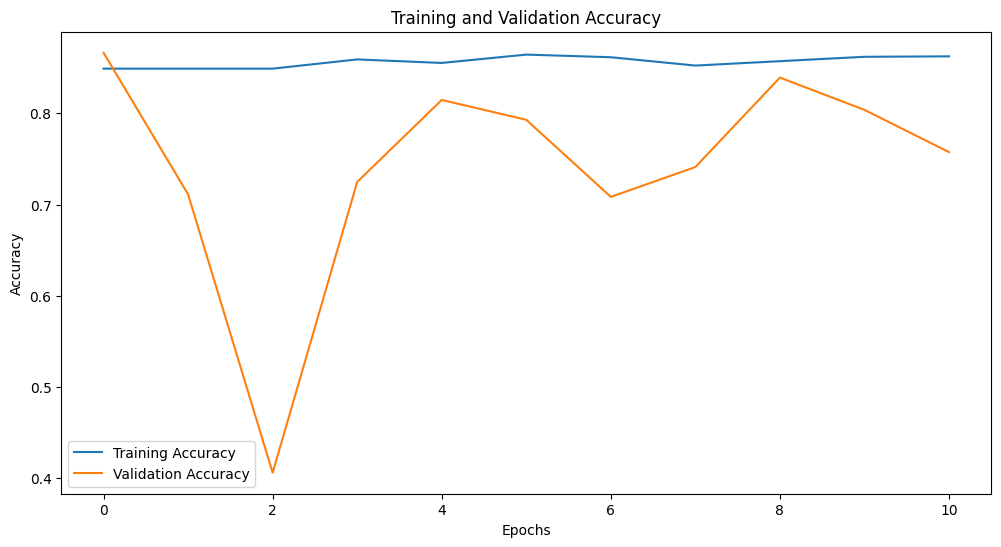

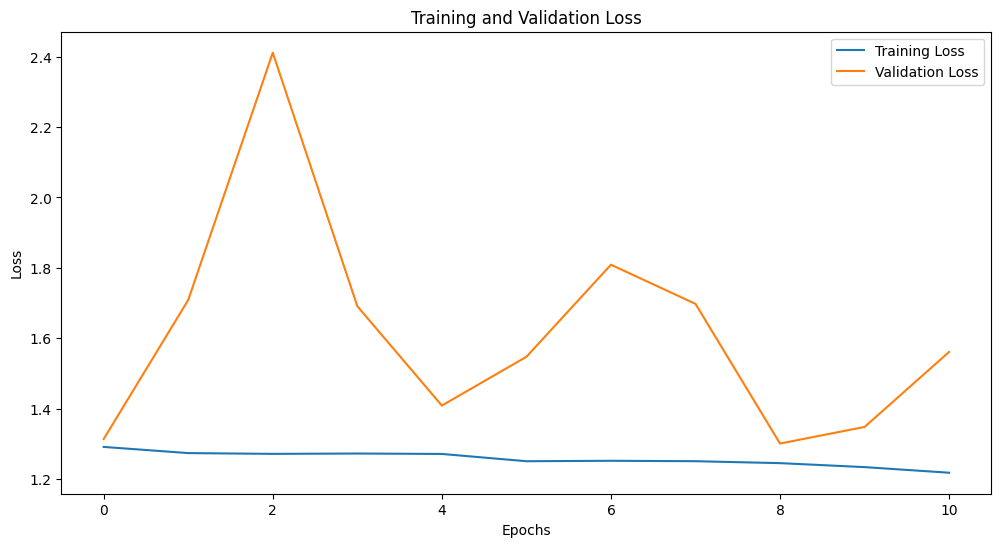

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sgd_history.history['accuracy'], label='Training Accuracy')
plt.plot(sgd_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(sgd_history.history['loss'], label='Training Loss')
plt.plot(sgd_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Load test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)



Found 621 files belonging to 4 classes.


In [ ]:
# Evaluate accuracy and loss
test_loss, test_accuracy = deep_model_sdg.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8450 - loss: 1.3504
Test Accuracy: 0.8502


In [ ]:
# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = deep_model_sdg.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Print classification report
from sklearn.metrics import classification_report

print("Classification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=class_names))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
Classification Report on Test Set:
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.86      0.86       181
meningioma_tumor       0.81      0.74      0.77       183
          no

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


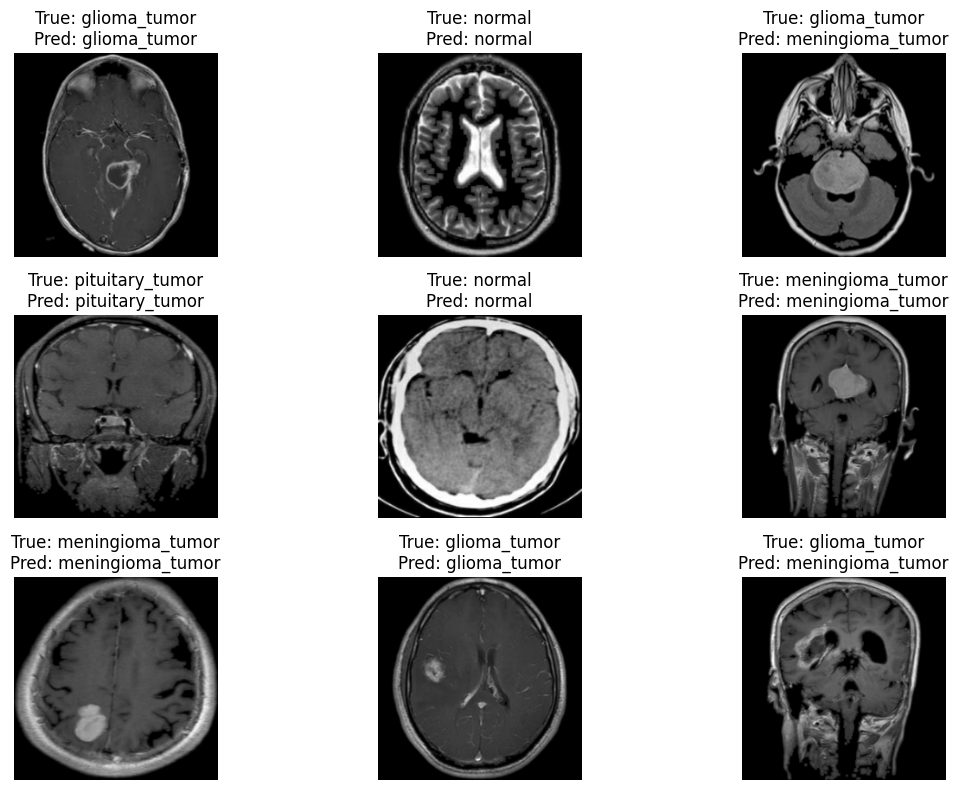

In [ ]:
for images, labels in test_ds.take(1):  # One batch
    predictions = deep_model_sdg.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


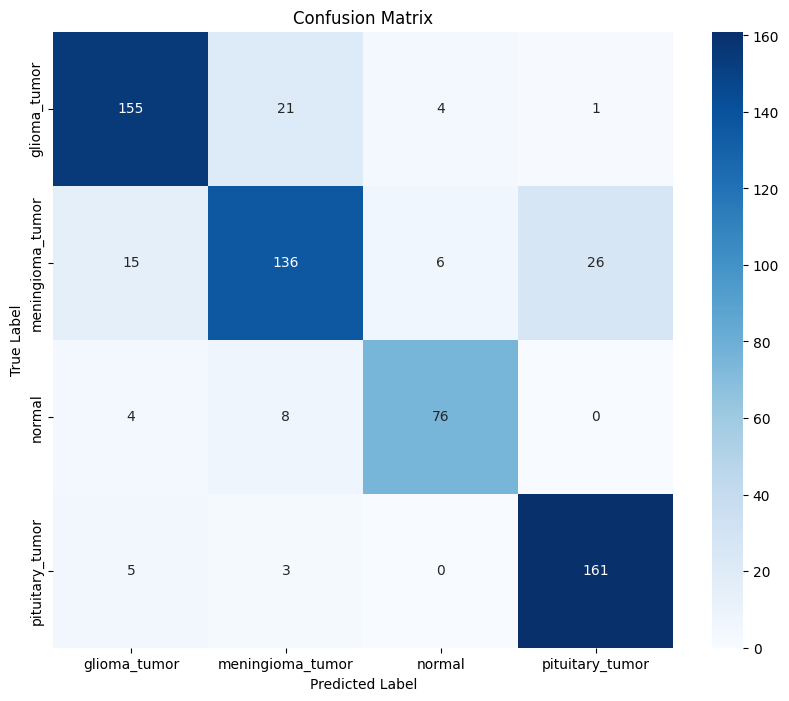

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Optimizer Analysis: SGD vs Adam

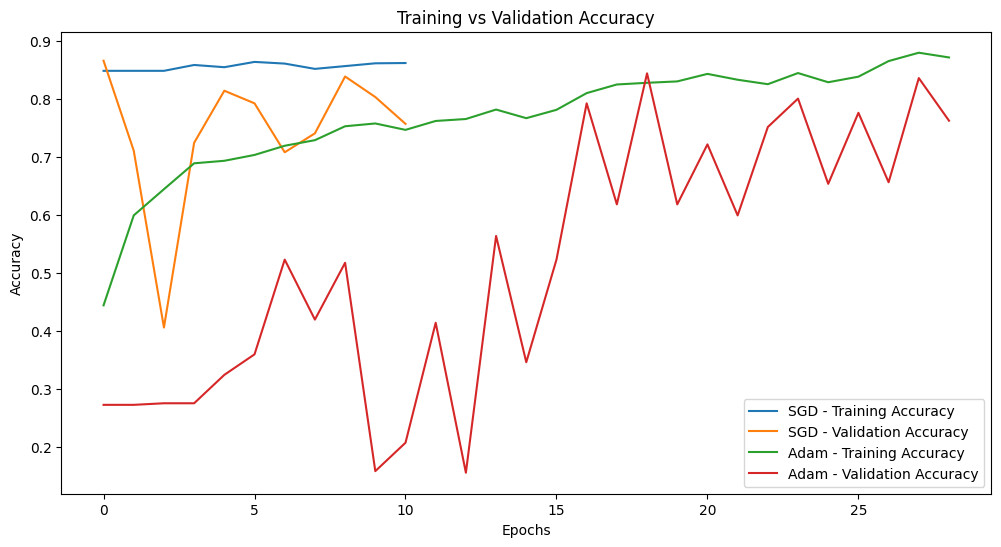

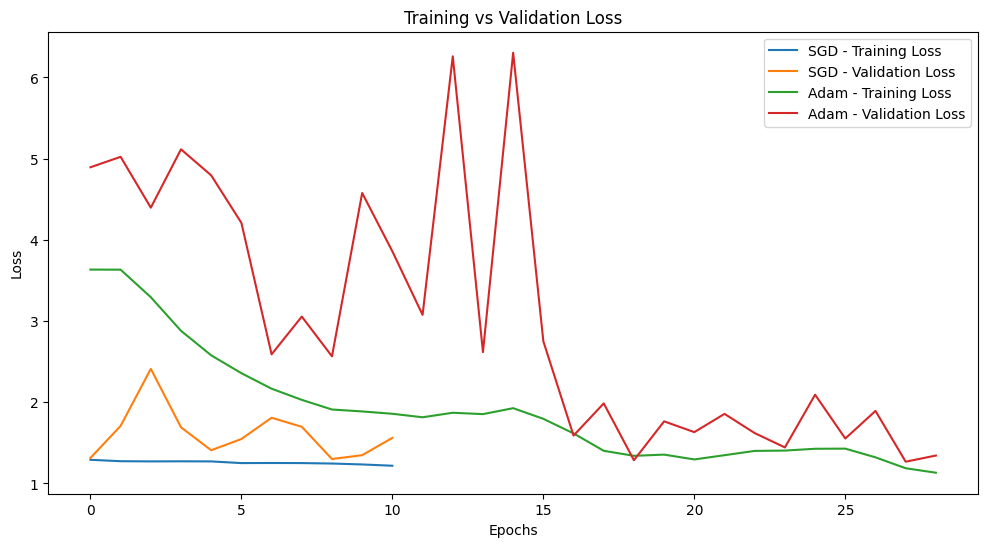

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Training and validation accuracy for SGD
plt.plot(sgd_history.history['accuracy'], label='SGD - Training Accuracy')
plt.plot(sgd_history.history['val_accuracy'], label='SGD - Validation Accuracy')

# Training and validation accuracy for Adam
plt.plot(history.history['accuracy'], label='Adam - Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Adam - Validation Accuracy')

plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Training and validation loss for SGD
plt.plot(sgd_history.history['loss'], label='SGD - Training Loss')
plt.plot(sgd_history.history['val_loss'], label='SGD - Validation Loss')

# Training and validation loss for Adam
plt.plot(history.history['loss'], label='Adam - Training Loss')
plt.plot(history.history['val_loss'], label='Adam - Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


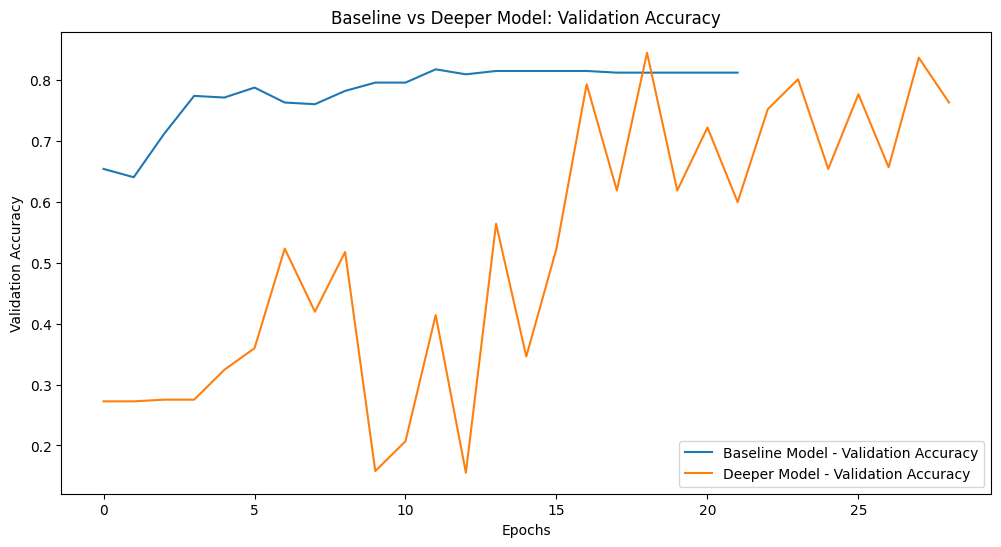

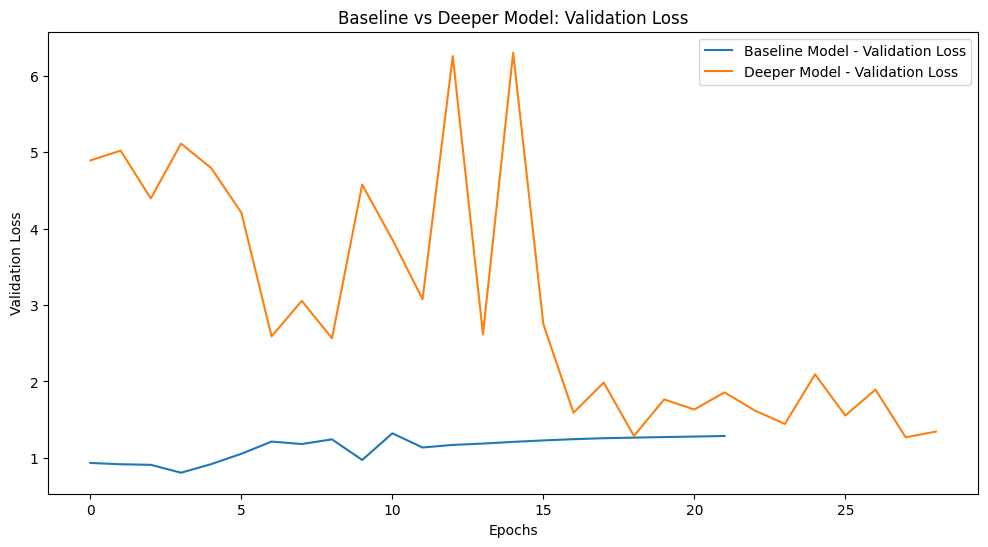

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 6))

plt.plot(base_history.history['val_accuracy'], label='Baseline Model - Validation Accuracy')
plt.plot(history.history['val_accuracy'], label='Deeper Model - Validation Accuracy')

plt.title('Baseline vs Deeper Model: Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))

plt.plot(base_history.history['val_loss'], label='Baseline Model - Validation Loss')
plt.plot(history.history['val_loss'], label='Deeper Model - Validation Loss')

plt.title('Baseline vs Deeper Model: Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


# Challenges and Observations

### Hardware Acceleration

 All models were trained on a T4 GPU in Google Colab, as confirmed by the notebook metadata ("gpuType": "T4") and training logs (“Training on GPU”).

## Baseline Model

**Overfitting**

---


While training baseline model
training accuracy reaches 1.00 and validation accuuracy 0.8093 by epoch 13. The validatioan loss increases from 0.8043 (epoch 4 ) to 1.2853 (epoch 22) which indicates the model is morizing training data. But thank fully we have used Early stopping which stop further training and restore the weigths form epoch 12. at 12th epoch weight we good best weight but it is still overfiiting we can apply regularization technique to mitigate this

**Total Training Time**

it takes around 614 second or 10.23 minutes to train up to 22 epochs on T4 GPU

## Deeper Model (Adam Optimizer):

**Overfitting**

---

On the Deeper model the training accuracy rises to 0.8726 at (epoch 28), while validation accuray peaks at 0.8447 at (epoch 19). model shows instablity its accuracy drops to 0.1580 in (epoch 10). Although we have applied Early Stopping at epoch 29 to restore the best weight at (epoch 19)



---

We got test accuracy of 0.8551, and F1-scros of 0.86 macro avg which shows better generalization than the baseline

---
**underfitting**
initally at epoch 1 we got high loss of 3.2816 and low validation accracy of 0.2725 which can be due to deepr architectures  complexity which ofter need more training data. however by epoch 19 it model learn effectively, mitigating underfitting concerns.


**Total Training Time**

it takes around 1,068 second or 17.8 minutes which indicates the dpper architecure complexity

## Deeper Model (SGD):

**Overfitting**

---
by epcoch 7 trainin accuracy reach to 0.8667 and high vlaidation accuray was 0.8665 at epoch 1. and stop by early stopping at epoch 11 .  



---

We got test accuracy of 0.8552, and F1-scros of 0.85 macro avg which shows slightly lower than the Adam-optimized deeper

---
**underfitting**
initally at epoch 1 we got high loss of 3.2816 and low validation accracy of 0.2725 which can be due to deepr architectures  complexity which ofter need more training data. however by epoch 19 it model learn effectively, mitigating underfitting concerns.


**Total Training Time**

it takes around 397 seconds or 6.62 minutes which indicates the dpper architecure complexity

# Conclusion:

The Deeper Model with Adam is the best due to its higher test accuracy of **0.8551**, better F1-scores, and ability to handle complex patterns, But needs tuning to mange instablity